In [11]:
import numpy as np
import scipy
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, mstats

https://pythonfordatascience.org/welch-t-test-python-pandas/

https://www.researchgate.net/post/Which_test_should_I_use_if_Im_comparing_a_non-normally_distributed_numeric_variable_with_a_normally_distributed_numeric_variable


https://medium.com/bigdatarepublic/contextual-changepoint-detection-with-python-and-r-using-rpy2-fa7d86259ba9

Piecewise regression
https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python

In [12]:
def shapiro_test_normality(x):
    return scipy.stats.shapiro(x)[1]

def wilcoxon(x, y): 
    t, p = scipy.stats.wilcoxon(x, y, correction=True)
    return p

def ranksums(x, y): 
    t, p = scipy.stats.ranksums(x, y)
    return p

def ks_test(x, y): 
    t, p = stats.ks_2samp(x, y)
    return p
def welch_ttest(x, y): 
    t, p = stats.ttest_ind(x, y, equal_var = False)
    return p

def anova(a1, a2):
    from scipy import stats
    F, p = stats.f_oneway(a1, a2)
    return p

def getPeaks(values, teta = 0.5):
    from scipy.signal import find_peaks
    peaksIdx=find_peaks(values)[0]
    peaksIdx = peaksIdx[np.where(values[peaksIdx]>=teta)]
    return peaksIdx

def z_score(a, mu): 
    mean = np.mean(a)
    sd = np.std(a)
    z = (abs((mu - mean)/sd))
#     p = 2*scipy.stats.norm.sf(abs(z))
    return z

def grubbs(a, mu):
    def z_score(mean, sd, mu):
        return(abs((mu - mean)/sd))
    mean = np.mean(a)
    sd = np.std(a)
    N = len(a)
    Z = z_score(mean, sd, mu)
    Z2 = Z**2
    tt = np.sqrt(np.abs((N*(N-2)*Z2)/(((N-1)**2)-(N*Z2))))     
    pval = scipy.stats.t.sf(abs(tt), N-1)*2
    return pval


def ttest_onesample(a, mu):
    return scipy.stats.ttest_1samp(a, mu ).pvalue




def mk_test(x, alpha = 0.05):  
    """   
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05) 
    """
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

def getChangePoints(data, test_method =welch_ttest,  window = 10, teta = 0.5, plot = False):
    # run statistical test
    anovapvalues = [1] * window
    
    for i in range(window, len(data) - window):
#         print(mk_test(data[i-window:i]), mk_test(data[i:i+window]))
        anovapvalues.append(test_method(data[i-window:i], data[i:i+window]))
    anovapvalues = -np.log(anovapvalues)
    anovapvalues /= max(anovapvalues)
    if plot:
        plt.figure()
        ax = plt.gca()
        plt.plot(data, alpha = 0.3, c = 'orange')
        ax2 = ax.twinx()
        plt.plot(anovapvalues)
        
    result = getPeaks(anovapvalues, teta)
    return result

def getChangePointsOneSample(data, test_method =ttest_onesample,  window = 10, teta = 0.9, plot = False):
    # run statistical test
    before = [1] * window
    after = [1] * window
    for i in range(window, len(data) - window):
#         print(mk_test(data[i-window:i]), mk_test(data[i:i+window]))
        before.append(test_method(data[i-window:i], data[i]))
        after.append(test_method(data[i+1:i+window+1], data[i]))
    values = np.array(before) + np.array(after)
    values = -np.log(values)

    values /= max(values)
    result = getPeaks(values, teta)
    if plot:
        plt.figure()
        ax = plt.gca()
        plt.plot(data, alpha = 0.3, c = 'orange')
        ax2 = ax.twinx()
        plt.plot(values)
        for i in result:
            plt.axvline(x = i, c ='red', linestyle='--', alpha = 0.2)
    
    return result

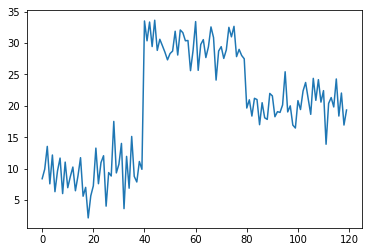

In [13]:
n = 40
data = np.concatenate( [
    np.random.normal(10, 4, n),
    np.random.normal(30, 2, n),
    np.random.normal(20, 3, n)])

plt.plot(data)

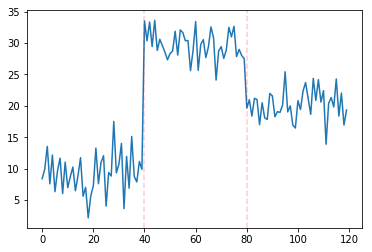

In [14]:
points = getChangePoints(data)
plt.plot(data)
for i in points:
    plt.axvline(x = i, c ='red', linestyle='--', alpha = 0.2)

# Measure change on diffs

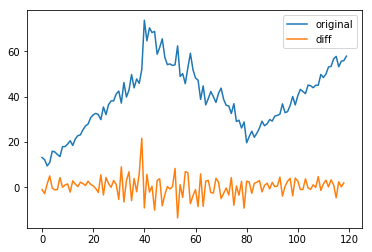

In [19]:
n=40
data = np.concatenate( [
    np.random.normal(10, 2, n) + np.arange(n),
    np.random.normal(30, 4, n) + np.arange(n)[::-1], 
    np.random.normal(20, 2, n) + + np.arange(n)])
diff = pd.Series(data).diff().dropna().values
plt.figure()
plt.plot(data, label = 'original')
plt.plot(diff, label = 'diff')
plt.legend()

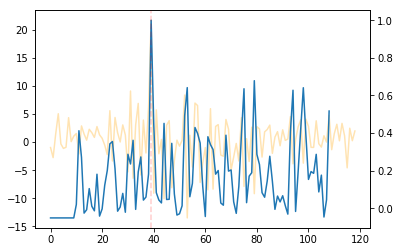

In [20]:
points = getChangePointsOneSample(diff, test_method= ttest_onesample,plot=True)

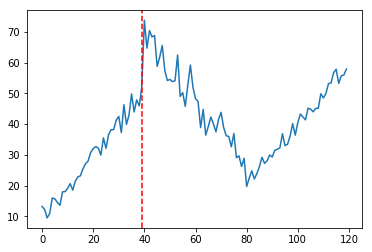

In [21]:
plt.figure()
plt.plot(data)
for i in points:
    plt.axvline(x = i, c ='red', linestyle='--')